# Starfysh tutorial on real dataset (w/o signature priors)

**Azizi Lab**

Siyu He, Yinuo Jin

09-07-2023

This is a tutorial on an example real Spatial Transcriptomics (ST) [data](https://drive.google.com/drive/folders/1RIp0Z2eF1m8Ortx0sgB4z5g5ISsRFzJ4?usp=share_link) (`CID44971_TNBC`) from [Wu *et al.*, 2021](https://www.nature.com/articles/s41588-021-00911-1). We specifically assume there's no curated gene signatures, and will use archetypal analysis to infer markers in a fully unsupervised fashion.

## Overview
Starfysh performs cell-type deconvolution followed by various downstream analyses to discover spatial interactions in tumor microenvironment. Specifically, Starfysh looks for *anchor spots* (presumably with the highest compositions of one given cell type) informed by user-provided gene signatures ([see example](https://drive.google.com/file/d/1AXWQy_mwzFEKNjAdrJjXuegB3onxJoOM/view?usp=share_link)) as priors to guide the deconvolution inference, which further enables downstream analyses such as sample integration, spatial hub characterization, cell-cell interactions, etc. This tutorial focuses on the deconvolution task. Overall, Starfysh provides the following options:

**Base feature**:

- Spot-level deconvolution (without signature priors) through generative modeling

In [2]:
import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip3 install scanpy
    !pip install git+https://github.com/azizilab/starfysh.git
    !pip install scikit-image --upgrade
    from google.colab import drive
    drive.mount('/content/drive')
    import sys

    # Please specify the colab notebook directory
    sys.path.append('/content/drive/MyDrive/Starfysh')

In [3]:
import os
import numpy as np
import pandas as pd
import torch

In [4]:
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import rcParams

import seaborn as sns
sns.set_style('white')

font_list = []
fpaths = matplotlib.font_manager.findSystemFonts()
for i in fpaths:
    try:
        f = matplotlib.font_manager.get_font(i)
        font_list.append(f.family_name)
    except RuntimeError:
        pass

font_list = set(font_list)
plot_font = 'Helvetica' if 'Helvetica' in font_list else 'FreeSans'

rcParams['font.family'] = plot_font
rcParams.update({'font.size': 10})
rcParams.update({'figure.dpi': 300})
rcParams.update({'figure.figsize': (3,3)})
rcParams.update({'savefig.dpi': 500})

import warnings
warnings.filterwarnings('ignore')

## Load starfysh

In [5]:
from starfysh import (AA, utils, plot_utils, post_analysis)
from starfysh import starfysh as sf_model

### (1). load data
File Input:
- Spatial transcriptomics
    - Count matrix: `adata`
    - (Optional): Paired histology & spot coordinates: `img`, `map_info`

- Annotated signatures (marker genes) for potential cell types: `gene_sig`

Starfysh is built upon scanpy and Anndata. The common ST/Visium data sample folder consists a expression count file (usually `filtered_featyur_bc_matrix.h5`), and a subdirectory with corresponding H&E image and spatial information, as provided by Visium platform.

For example, our example real ST data has the following structure:
```
├── ../data
    bc_signatures_version_1013.csv

    ├── P1A_ER:
        \__ filtered_feature_bc_mactrix.h5

        ├── spatial:
            \__ aligned_fiducials.jpg
                detected_tissue_image.jpg
                scalefactors_json.json
                tissue_hires_image.png
                tissue_lowres_image.png
                tissue_positions_list.csv
```

For data that doesn't follow the common visium data structure (e.g. missing `filtered_featyur_bc_matrix.h5` or the given `.h5ad` count matrix file lacks spatial metadata), please construct the data as Anndata synthesizing information as the example simulated data shows:

[Note]: If you're running this tutorial locally, please download the sample [data](https://drive.google.com/drive/folders/1RIp0Z2eF1m8Ortx0sgB4z5g5ISsRFzJ4?usp=share_link) and [signature gene sets](https://drive.google.com/file/d/1AXWQy_mwzFEKNjAdrJjXuegB3onxJoOM/view?usp=share_link), and save it in the relative path `../data` (otherwise please modify the `data_path` defined in the cell below):

In [6]:
# Specify data paths
data_path = '../data/'
sample_id = 'CID44971_TNBC'
sig_name = 'bc_signatures_version_1013.csv'

In [7]:
# Load expression counts and signature gene sets
adata, adata_normed = utils.load_adata(data_folder=data_path,
                                       sample_id=sample_id, # sample id
                                       n_genes=2000  # number of highly variable genes to keep
                                       )


[2024-04-02 17:26:38] Preprocessing1: delete the mt and rp
[2024-04-02 17:26:38] Preprocessing2: Normalize
[2024-04-02 17:26:38] Preprocessing3: Logarithm
[2024-04-02 17:26:38] Preprocessing4: Find the variable genes


In [8]:
adata

AnnData object with n_obs × n_vars = 1162 × 18954
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'features', 'highly_variable'

... storing 'sample' as categorical


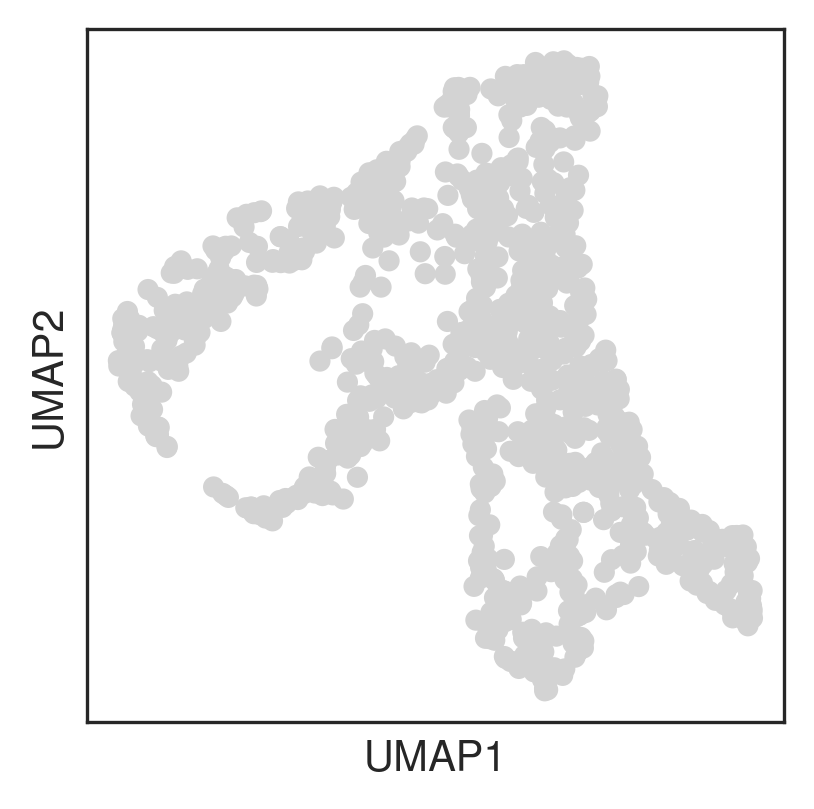

In [9]:
# Load spatial information
img_metadata = utils.preprocess_img(data_path,
                                    sample_id,
                                    adata_index=adata.obs.index,
                                    hchannel=False
                                    )
img, map_info, scalefactor = img_metadata['img'], img_metadata['map_info'], img_metadata['scalefactor']
umap_df = utils.get_umap(adata, display=True)

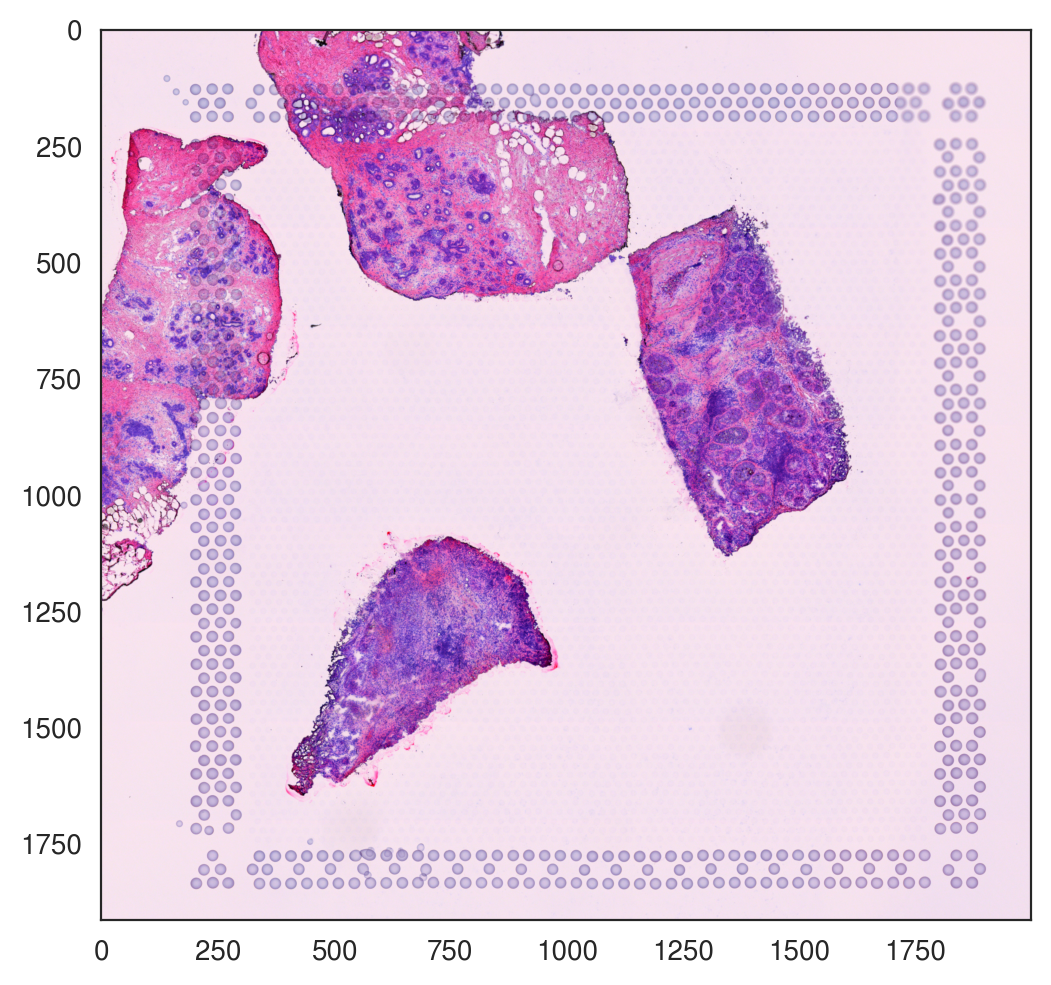

In [10]:
plt.figure(figsize=(6, 6), dpi=200)
plt.imshow(img)
plt.show()

In [11]:
map_info.head()

array_row  array_col  imagerow  imagecol         sample
AACATTGGTCAGCCGT-1          3         17      1361      2511  CID44971_TNBC
CATCGAATGGATCTCT-1          3         19      1361      2620  CID44971_TNBC
CGGGTTGTAGCTTTGG-1          3         21      1361      2730  CID44971_TNBC
CCTAAGTGTCTAACCG-1          2         22      1266      2784  CID44971_TNBC
TCTGTGACTGACCGTT-1          3         23      1361      2839  CID44971_TNBC

### (2). Find markers with Archetypal Analysis

If users don't provide annotated gene signature sets with cell types, Starfysh identifies candidates for cell types via archetypal analysis (AA). The underlying assumption is that the geometric "extremes" are identified as the purest cell types, whereas all other spots are mixture of the "archetypes". Archetypal communities and the corresponding markers are identified accordingly.

Note: <br>
- Intrinsic Dimension (ID) estimator is implemented to estimate the lower-bound for the number of archetypes $k$, followed by elbow method with iterations to identify the optimal $k$. By default, a [conditional number](https://scikit-dimension.readthedocs.io/en/latest/skdim.id.FisherS.html) is set as 30; if you believe there are potentially more / fewer cell types, please increase / decrease `cn` accordingly.

In [12]:
aa_model = AA.ArchetypalAnalysis(adata_orig=adata)
archetype, arche_dict, major_idx, evs = aa_model.compute_archetypes()

# (1). Find archetypal spots & archetypal clusters
arche_df = aa_model.find_archetypal_spots(major=True)

[2024-04-02 17:26:54] Computing intrinsic dimension to estimate k...


7 components are retained using conditional_number=30.00


[2024-04-02 17:26:55] Estimating lower bound of # archetype as 3...
[2024-04-02 17:27:47] 0.9479 variance explained by raw archetypes.
Merging raw archetypes within 100 NNs to get major archetypes
[2024-04-02 17:27:47] Finding 100 nearest neighbors for each archetype...


In [13]:
# (2). Define "signature genes" as marker genes associated with each archetypal cluster
gene_sig = aa_model.find_markers(display=False)
gene_sig.head()

[2024-04-02 17:27:47] Finding 30 top marker genes for each archetype...


arch_0  arch_1     arch_3  arch_4 arch_6 arch_10 arch_12 arch_18 arch_20
0  IGHG4  EEF1A1     MALAT1     MGP   IGKC     B2M    GNAS   FDCSP   RPL34
1  IGLC2    TUBB  MTRNR2L12   RPL41  IGLC2    CD74    TUBB   HLA-C  RPL10A
2   IGKC    GNAS     COL1A2  RPS27A  IGHG4   HLA-B   YWHAQ   HLA-A   RPL41
3  IGHG1   STMN1   HSP90AA1   RPL17  IGHG3   HLA-A  EEF1A1     B2M  RPL35A
4  IGHG3   YWHAQ       CTGF   RPS13  IGHG1  TMSB4X  TUBA1B     FTL   RPS24

- Visualize archetypes

[2024-04-02 17:27:56] Calculating UMAPs for counts + Archetypes...
[2024-04-02 17:28:01] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(<Figure size 1800x1200 with 1 Axes>, <AxesSubplot:>)

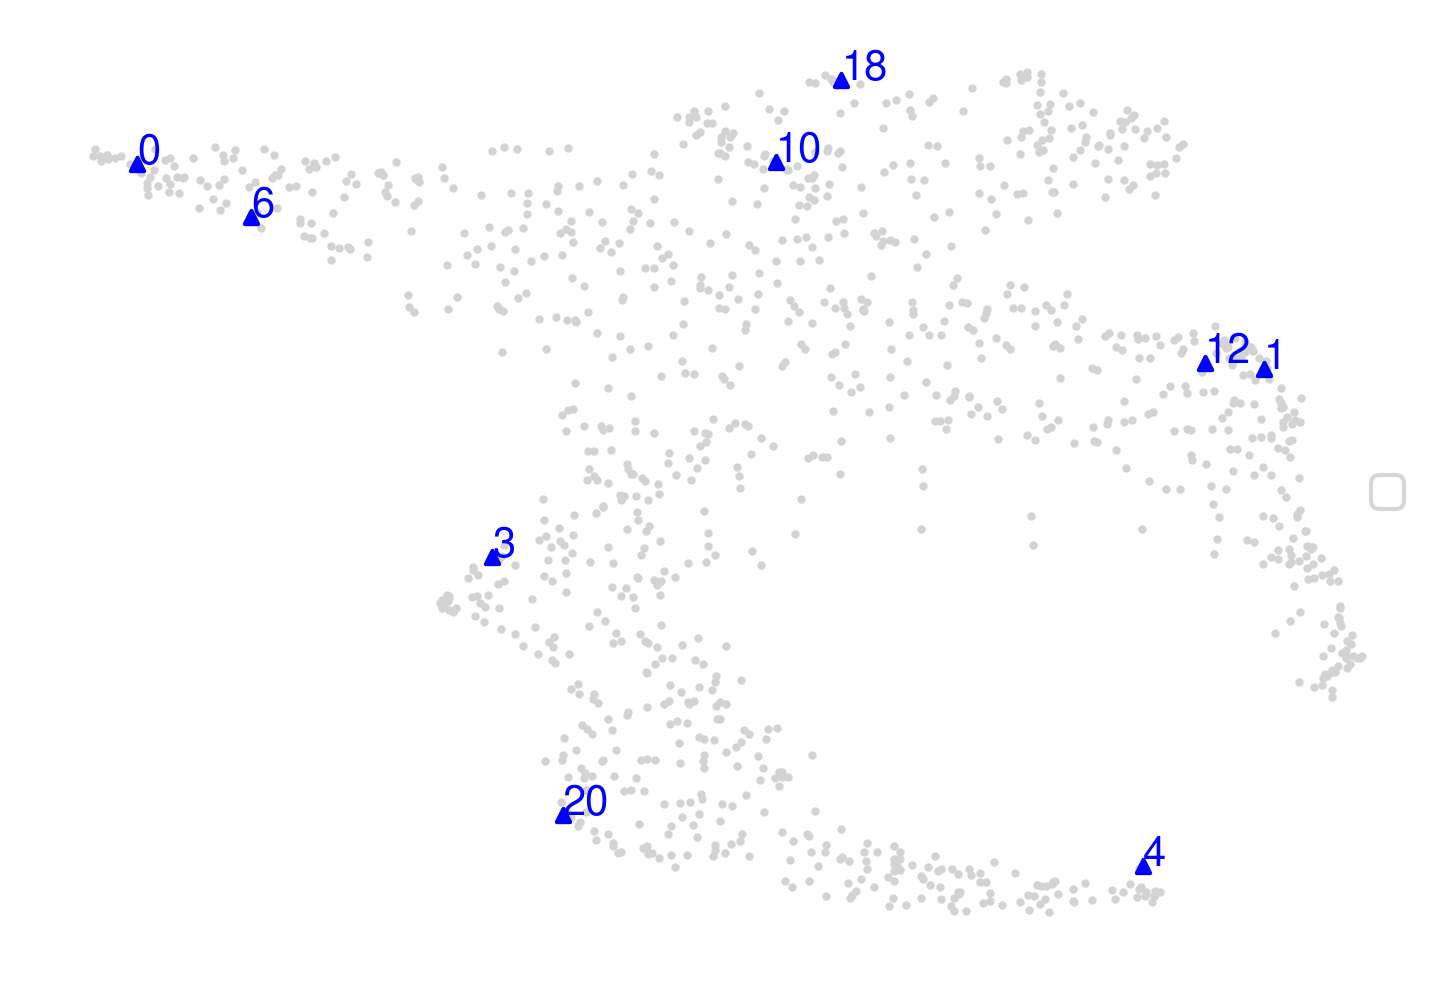

In [14]:
aa_model.plot_archetypes(do_3d=False, major=True, disp_cluster=False)

### (3). Preprocessing 

Instantiate parameters for Starfysh model training:
- Raw & normalized counts after taking highly variable genes
- filtered signature genes (from archetypal analysis) & the priors


In [15]:
# Parameters for training
visium_args = utils.VisiumArguments(adata,
                                    adata_normed,
                                    gene_sig,
                                    img_metadata,
                                    sample_id=sample_id
                                   )

adata, adata_normed = visium_args.get_adata()
anchors_df = visium_args.get_anchors()


[2024-04-02 17:28:01] Subsetting highly variable & signature genes ...


[2024-04-02 17:28:05] Smoothing library size by taking averaging with neighbor spots...
[2024-04-02 17:28:06] Retrieving & normalizing signature gene expressions...
[2024-04-02 17:28:06] Identifying anchor spots (highly expression of specific cell-type signatures)...


- Visualize the spatial data

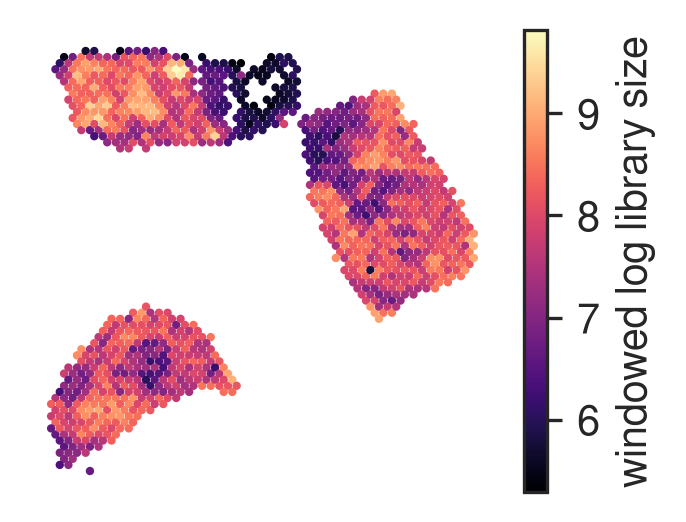

In [17]:
plot_utils.plot_spatial_feature(map_info,
                                visium_args.win_loglib,
                                label='windowed log library size')

plot raw gene expression:

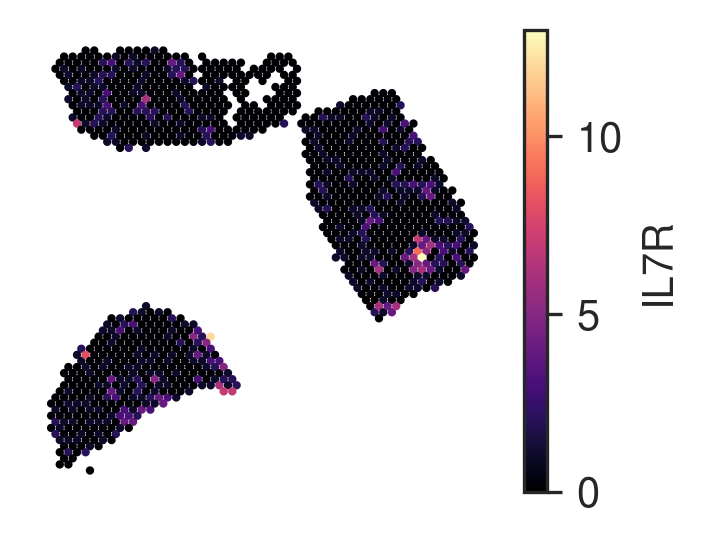

In [18]:
plot_utils.plot_spatial_gene(adata,
                             map_info,
                             gene_name='IL7R')

## Run starfysh


We perform `n_repeat` random restarts and select the best model with lowest loss for parameter `c` (inferred cell-type proportions):


### (1). Model parameters

In [19]:
n_repeats = 3
epochs = 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### (2). Model training

Users can choose to run the one of the following `Starfysh` model without/with histology integration:

- Without histology integration: setting `utils.run_starfysh(poe=False)` (default)
- With histology integration: setting `utils.run_starfysh(poe=True)`

In [20]:
model, loss = utils.run_starfysh(visium_args,
                                 n_repeats=n_repeats,
                                 epochs=epochs,
                                 # poe=True, # Turn on/off for model with/without histology integration
                                 device=device)

[2024-04-02 17:28:35] Running Starfysh with 3 restarts, choose the model with best parameters...
[2024-04-02 17:28:35] Initializing model parameters...
[2024-04-02 17:28:41] Epoch[10/200], train_loss: 3840.2518, train_reconst: 3703.4891, train_u: 18.0363,train_z: 36.0014,train_c: 49.5590,train_l: 33.1659
[2024-04-02 17:28:47] Epoch[20/200], train_loss: 1791.6289, train_reconst: 1693.1345, train_u: 17.9796,train_z: 32.4377,train_c: 45.8769,train_l: 2.2002
[2024-04-02 17:28:53] Epoch[30/200], train_loss: 1424.9160, train_reconst: 1333.1209, train_u: 17.9157,train_z: 29.5373,train_c: 43.3195,train_l: 1.0225
[2024-04-02 17:28:59] Epoch[40/200], train_loss: 1394.9795, train_reconst: 1307.9267, train_u: 17.8647,train_z: 25.9018,train_c: 41.9850,train_l: 1.3013
[2024-04-02 17:29:05] Epoch[50/200], train_loss: 1378.3569, train_reconst: 1292.9601, train_u: 17.8248,train_z: 24.7497,train_c: 41.3350,train_l: 1.4873
[2024-04-02 17:29:11] Epoch[60/200], train_loss: 1370.7208, train_reconst: 1287.04

##  Downstream analysis

### Parse Starfysh inference output

In [22]:
adata, adata_normed = visium_args.get_adata()
inference_outputs, generative_outputs = sf_model.model_eval(model,
                                                            adata,
                                                            visium_args,
                                                            # poe=True, # Turn on/off for model with/without histology integration
                                                            device=device)

### Visualize starfysh deconvolution results


### Spatial visualizations:

Inferred density on Spatial map:

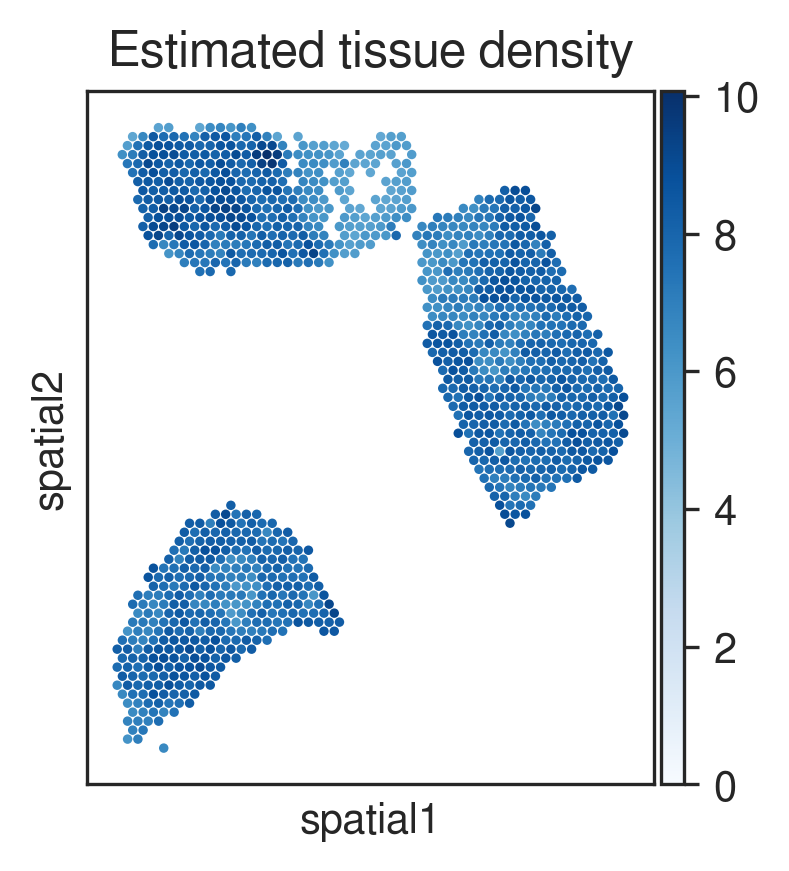

In [23]:
plot_utils.pl_spatial_inf_feature(adata, feature='ql_m', cmap='Blues')

**Inferred cell-type proportions (spatial map):**

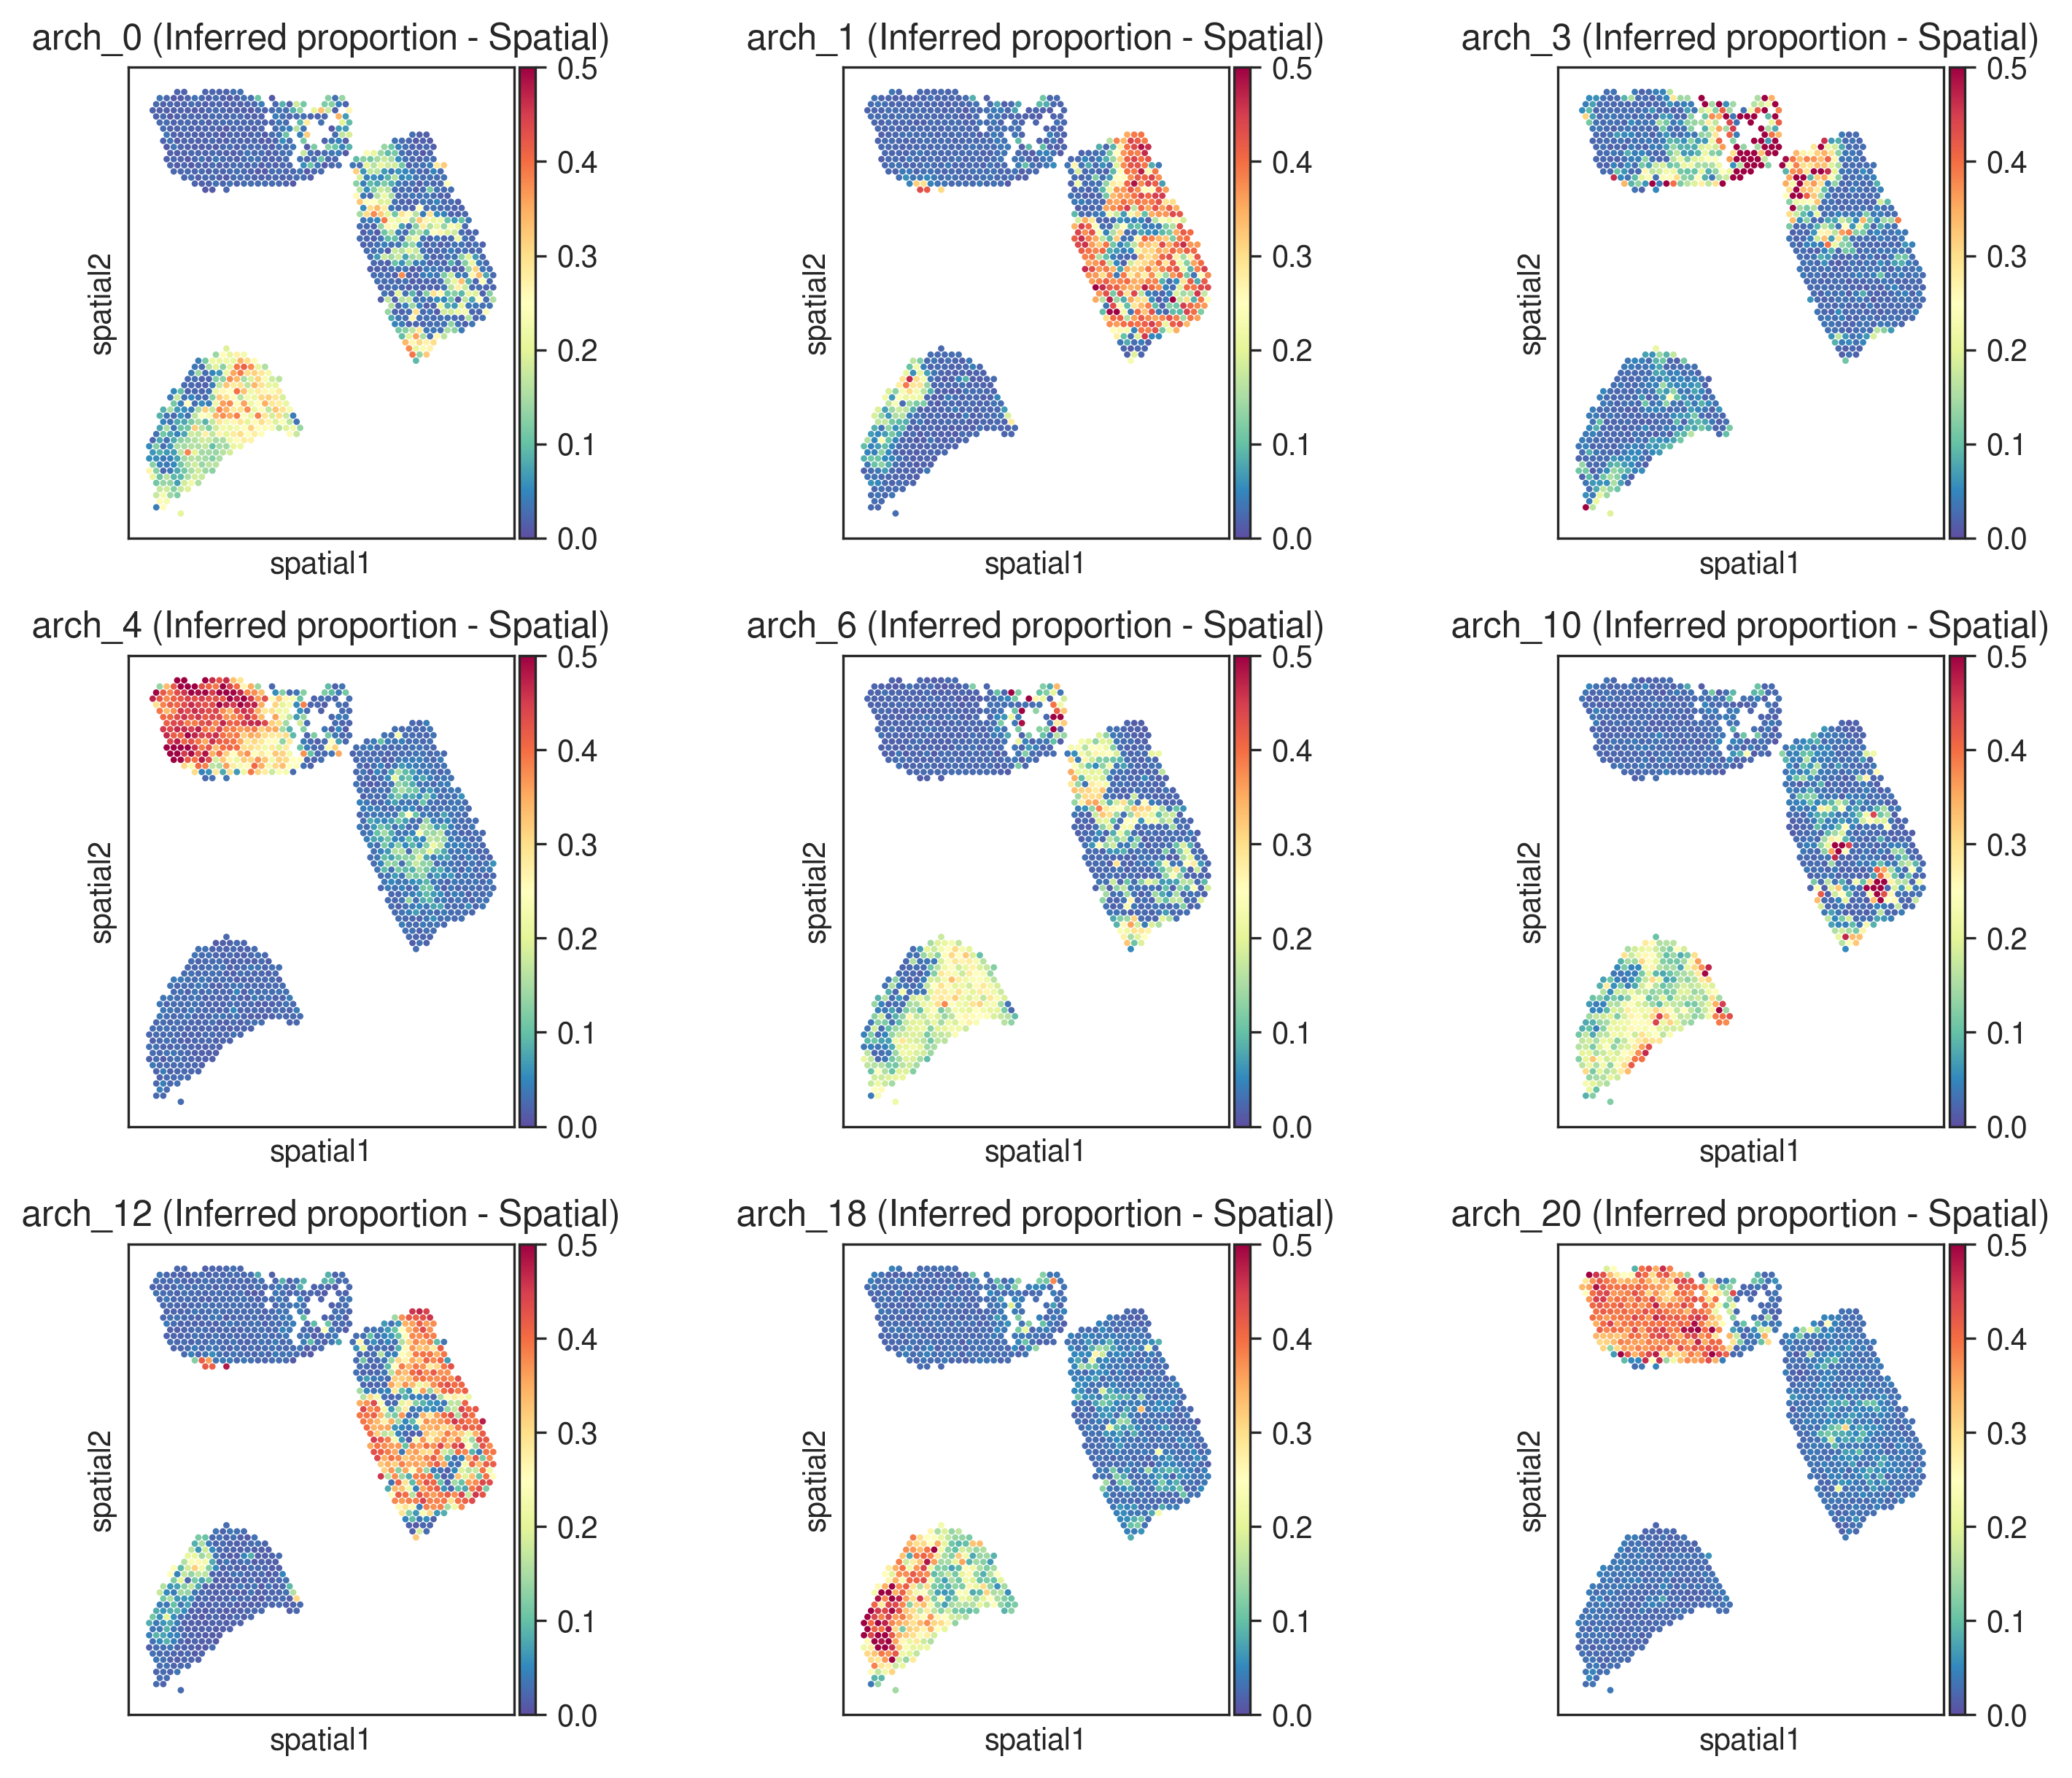

In [24]:
plot_utils.pl_spatial_inf_feature(adata,
                                  feature='qc_m',
                                  # To display for specific cell types:
                                  # factor = cell type or factor = [cell type1, ...]
                                  vmax=0.5)

**Inferred cell-type proportions on Z-space (UMAP):**

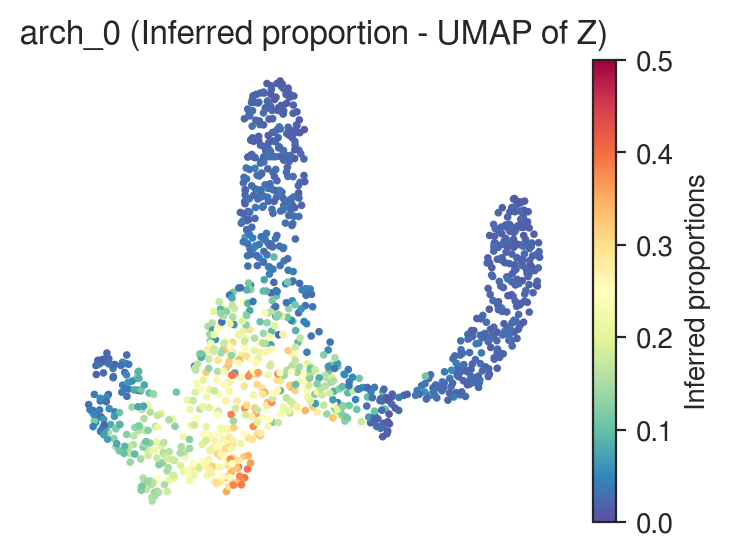

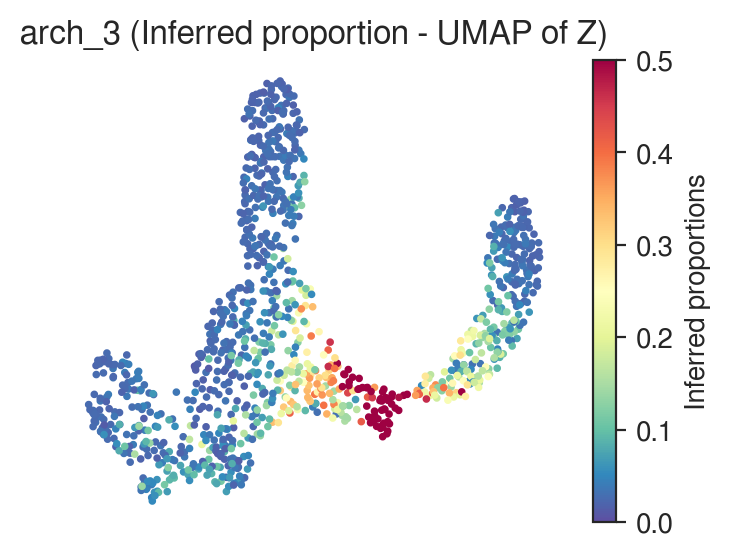

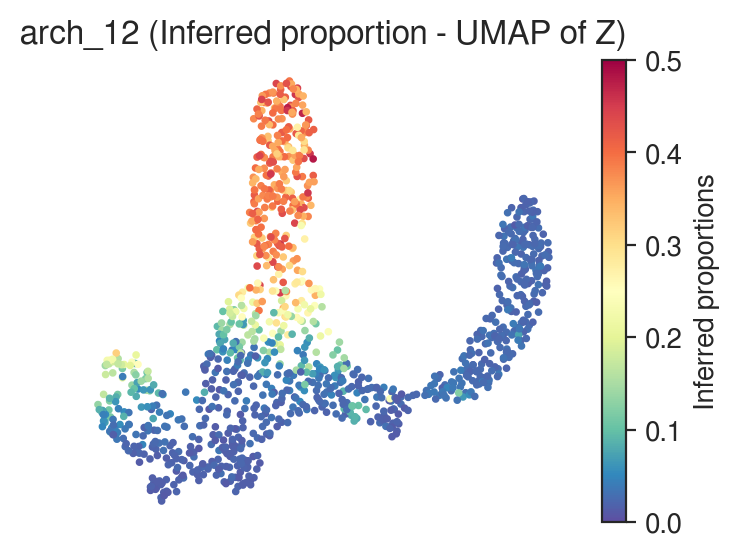

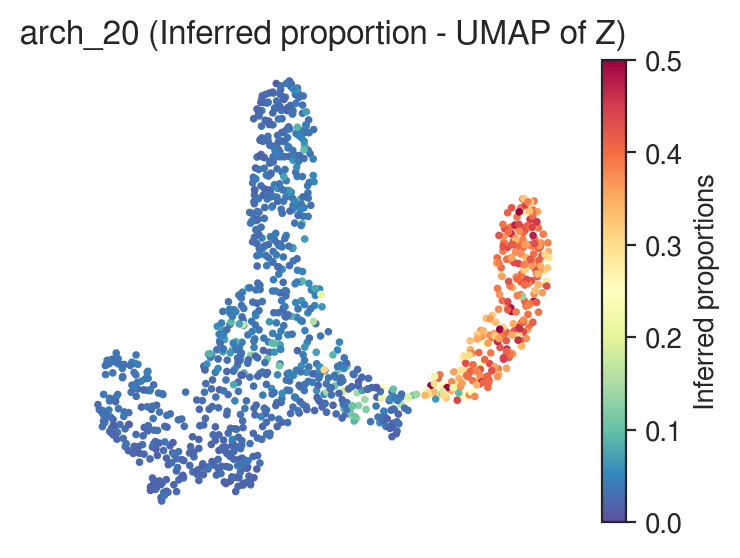

In [29]:
plot_utils.pl_spatial_inf_feature(adata,
                                  feature='qz_m',
                                  # To display for specific cell types:
                                  # factor = Cell type or factor = [Cell type1, ...]
                                  factor=['arch_0', 'arch_3', 'arch_12', 'arch_20'],
                                  spot_size=3,
                                  vmax=0.5)


**Infer cell-type specific expressions from each spot**

In [30]:
pred_exprs = sf_model.model_ct_exp(model,
                                   adata,
                                   visium_args,
                                   device=device)

Plot spot-level expression (e.g. `IL7R` from *arch_14*):


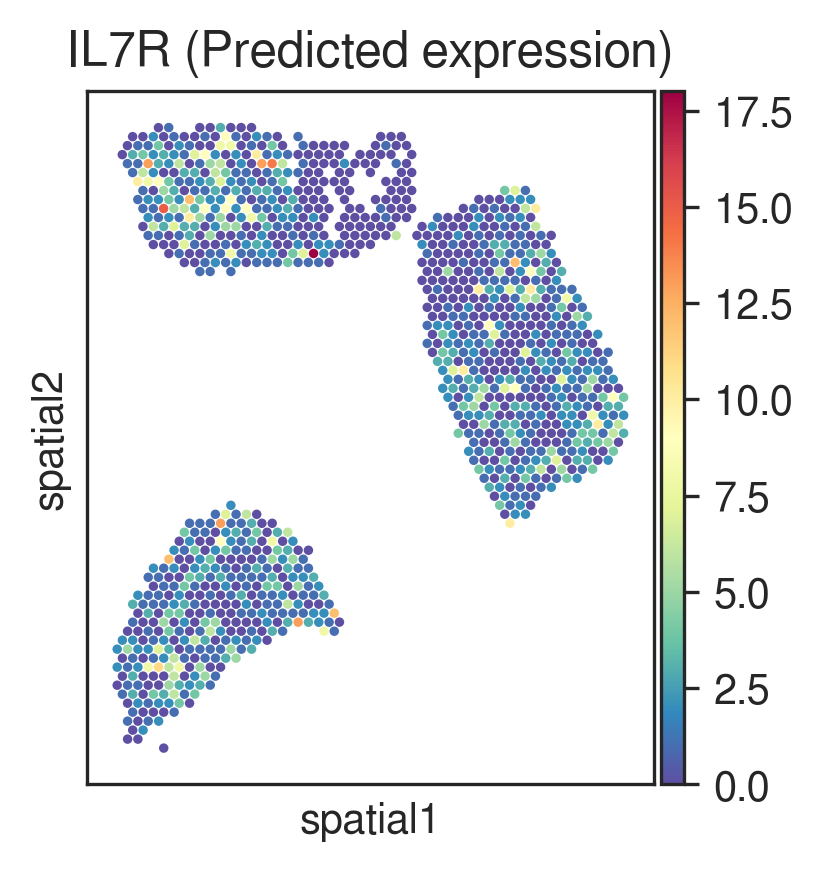

In [31]:
sample_gene = 'IL7R'
sample_cell_type = 'arch_12'

plot_utils.pl_spatial_inf_gene(adata,
                               factor=sample_cell_type,
                               feature=sample_gene)

## Save model & inferred parameters

In [32]:
# Specify output directory
outdir = './results/'
if not os.path.exists(outdir):
    os.mkdir(outdir)

# save the model
torch.save(model.state_dict(), os.path.join(outdir, 'starfysh_model.pt'))

# save `adata` object with inferred parameters
adata.write(os.path.join(outdir, 'st.h5ad'))



---